<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Ensemble_Models/Example_Ensemble_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading the car dataset from UCI machine learning databases
import pandas as pd
import numpy as np

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
header = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
          'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
          'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
          'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
          'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg',
          'price']

df = pd.read_csv(url, names=header, na_values='?')

cols_with_missing = df.isnull().sum()
cols_with_missing[cols_with_missing > 0]


normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64

In [2]:
# price is the target variable so remove the 4 records where price is missing
# also drop normalized-losses as there are too many missings
df = df[~df['price'].isnull()]
df = df.drop(labels=['normalized-losses'], axis=1)

In [3]:
features = {
    'categorical': ['make', 'fuel-type', 'aspiration', 'num-of-doors',
                    'body-style', 'drive-wheels', 'engine-location',
                    'engine-type', 'num-of-cylinders', 'fuel-system'],
    'numerical': ['symboling', 'wheel-base', 'length', 'width', 'height',
                  'curb-weight', 'engine-size', 'bore', 'stroke',
                  'compression-ratio', 'horsepower', 'peak-rpm',
                  'city-mpg', 'highway-mpg']}

features['all'] = features['categorical'] + features['numerical']

target = 'price'

df[target] = df[target].astype(np.float64)/1000

df[features['categorical']].sample(n=3,random_state=42)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
98,nissan,gas,std,two,hardtop,fwd,front,ohc,four,2bbl
16,bmw,gas,std,two,sedan,rwd,front,ohc,six,mpfi
31,honda,gas,std,two,hatchback,fwd,front,ohc,four,1bbl


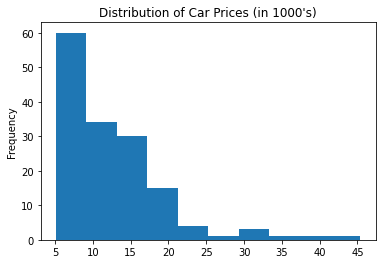

In [4]:
# Split the data into training and test sets
# All other transformations, such as scaling, imputing, and encoding, should be 
# done after splitting the data into training and test sets. In this way, we can
# ensure that no information is leaked from the test set into the training samples.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
x_train = df_train[features['all']]
x_test = df_test[features['all']]
y_train = df_train[target]
y_test = df_test[target]

y_train.plot(title="Distribution of Car Prices (in 1000's)",kind='hist')

In [5]:
# The transform function returns numpy ndarrays
# In order to keep the column names:
class ColumnNamesKeeper:
  def __init__(self, transformer):
    self._columns = None
    self.transformer = transformer
  
  def fit(self, x, y=None):
    self._columns = x.columns
    self.transformer.fit(x)

  def transform(self, x, y=None):
    x = self.transformer.transform(x)
    return pd.DataFrame(x, columns=self._columns)

  def fit_transform(self, x, y=None):
    self.fit(x,y)
    return self.transform(x)

In [6]:
# Impute missing values with the most frequent value in each column
# Need to eliminate all missing values before training ensemble models
from sklearn.impute import SimpleImputer

imp = ColumnNamesKeeper(SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
x_train = imp.fit_transform(x_train)
x_test = imp.transform(x_test)

In [ ]:
!pip install category_encoders

In [ ]:
# Encoding cateogrical columns
from category_encoders.ordinal import OrdinalEncoder

enc = OrdinalEncoder(cols=features['categorical'], handle_unknown='value')
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

In [9]:
# Using Random Forest for regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             median_absolute_error, r2_score)

rgr = RandomForestRegressor(n_jobs=-1)
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)

print('R2: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}, MAE {:.2f}'.format(
  r2_score(y_test, y_test_pred),
  mean_squared_error(y_test, y_test_pred),
  np.sqrt(mean_squared_error(y_test, y_test_pred)),
  mean_absolute_error(y_test, y_test_pred)))
print("Average car price: {:.2f}".format(df[target].mean()))

R2: 0.93, MSE: 7.72, RMSE: 2.78, MAE 1.73
Average car price: 13.21


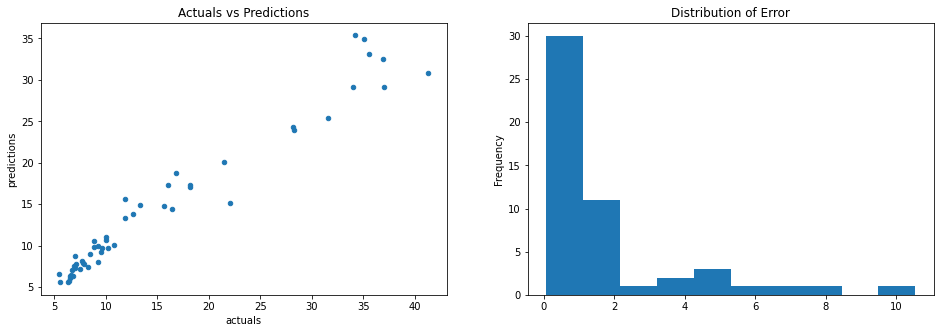

In [10]:
import matplotlib.pyplot as plt

df_pred = pd.DataFrame({
    'actuals': y_test,
    'predictions': y_test_pred
})
df_pred['error'] = np.abs(y_test - y_test_pred)

fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=False)

df_pred.plot(
    title='Actuals vs Predictions',
    kind='scatter',
    x='actuals',
    y='predictions',
    ax=axs[0]
)

df_pred['error'].plot(
    title='Distribution of Error',
    kind='hist',
    ax=axs[1]
)

fig.show()

In [18]:
# Check of effect of different numbers of trees
mae = []
n_estimators_options = [5, 500, 5000]

for n_estimators in n_estimators_options:
  rgr = RandomForestRegressor(
      n_estimators=n_estimators,
      bootstrap=True,
      max_features=0.75,
      max_samples=0.75,
      n_jobs=-1
  )
  rgr.fit(x_train, y_train)
  y_test_pred = rgr.predict(x_test)
  mae.append(mean_absolute_error(y_test, y_test_pred))

In [19]:
mae

[1.794657516339869, 2.0429078986928104, 2.0253120460784957]

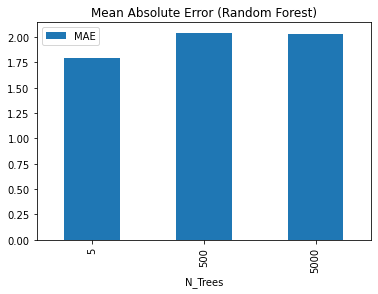

In [29]:
pd.DataFrame({'MAE': mae, 'N_Trees': n_estimators_options}).plot.bar(x='N_Trees',y='MAE',
                                                                     title='Mean Absolute Error (Random Forest)')

In [32]:
# Feature importance
df_feature_importance = pd.DataFrame(
    {'Feature': x_train.columns,
     'Importance': rgr.feature_importances_
    }
).sort_values('Importance', ascending=False)

df_feature_importance

,Feature,Importance
15,curb-weight,0.298065
16,engine-size,0.276080
20,horsepower,0.110854
23,highway-mpg,0.082891
22,city-mpg,0.071272
13,width,0.041577
11,wheel-base,0.027369
12,length,0.026445
17,bore,0.009796
21,peak-rpm,0.008637


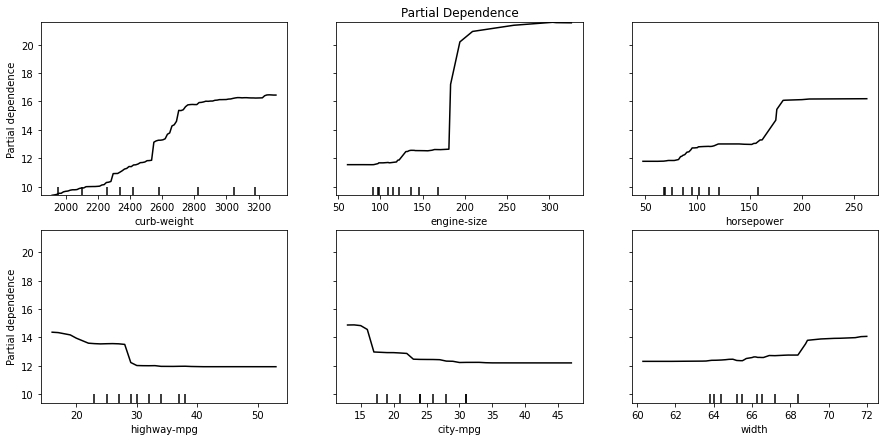

In [35]:
# Partial Dependence Plot (PDP)
from sklearn.inspection import PartialDependenceDisplay

top_features = df_feature_importance['Feature'].head(6)
fig, ax = plt.subplots(1,1,figsize=(15,7), sharey=False)
PartialDependenceDisplay.from_estimator(
    rgr, x_train, features=top_features, n_cols=3, n_jobs=-1,
    line_kw={'color': 'k'},
    ax=ax
)
ax.set_title('Partial Dependence')
fig.show()

In [ ]:
# Using random forest for classification
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

x, y = make_hastie_10_2(n_samples=6000, random_state=87)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=87)

clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred_proba = clf.predict_proba(x_test)[:,1]
fpr, tpr, tnr = roc_curve(y_test, y_pred_proba)

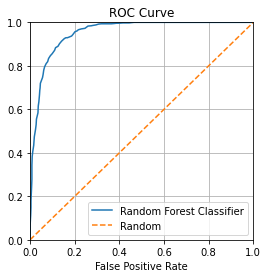

In [53]:
ax = pd.DataFrame(
    {'FPR': fpr, 'TPR': tpr}
).set_index('FPR')['TPR'].plot(title='ROC Curve', label='Random Forest Classifier', 
                               grid=True,kind='line',xlabel='False Positive Rate',
                               figsize=(4,4),xlim=(0,1),ylim=(0,1))

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls='--', label='Random')
ax.legend(loc="lower right")